# 2x Single-Image Super-Resolution on Grayscale Images

**Assignment:** Individual Class Project<br>
**Author:** Richard Hemphill<br>
**ID:** 903877709<br>
**Class:** ECE5268 Theory of Neural Networks<br>
**Instructor:** Dr. Georgios C. Anagnostopoulos<br>
**Description:** Using small-sized grayscale images, construct a CNN-based architecture that will downscale (magnify) the images by a factor of 2.<br>
**Emphasis:** Describe the concept of single-image super-resolution, describe the architecture in sufficient detail and show indicative training and post-training results.<br>


**References:**
* https://www.kaggle.com/spaceengineer1/alexonly-greyscale
* https://www.kaggle.com/c/two-sigma-financial-news/discussion/83593
* https://scikit-image.org/docs/dev/auto_examples/transform/plot_rescale.html

In [91]:
# Imports
import os.path
import math
import random
import shutil
import glob
import PIL
from IPython.display import display
from pathlib import Path
from zipfile import ZipFile
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from kaggle.api.kaggle_api_extended import KaggleApi
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.python.client import device_lib

In [92]:
# Constants
CURRENT_DIRECTORY = '.'
RANDRANGE_STOP = 10000
EPOCHS = 1000
BATCH_SIZE = 10
IMAGE_SET_OWNER = 'spaceengineer1'
IMAGE_SET_FILE = 'alexonly-greyscale'
ZIP_EXTENSION = 'zip'
IMAGE_EXTENSION = 'jpg'
PROCESSED_IMAGE_FOLDER ='dataSet'
TRAIN_FOLDER = 'train'
TEST_FOLDER = 'test'
RESCALE_FACTOR = 255.0
VALIDATION_SPLIT = 0.2
CHANNELS = 1
ORIG_IMG_SIZE = 256
UPSCALE_FACTOR = 2
LOW_RES_IMG_SIZE = int(ORIG_IMG_SIZE/UPSCALE_FACTOR)

In [93]:
# set figure's width 5 inches, and its height 10 inches
rcParams['figure.figsize'] = 8, 8

In [94]:
# Check if Tensorflow is using GPU
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


## Utility Functions

In [95]:
def ImageNorm(image):
    image = image/RESCALE_FACTOR
    return image

In [96]:
def Shrink(input):
    return tf.image.resize(input,[LOW_RES_IMG_SIZE,LOW_RES_IMG_SIZE],method='area')

In [97]:
def MagnifyImage(model, lowResImg):
    lowResArr = img_to_array(lowResImg)
    lowResArr = lowResArr.astype('float32')/RESCALE_FACTOR
    lowResArr = np.expand_dims(lowResArr, axis=0)
    hiResArr = model.predict(lowResArr)
    hiResArr *= RESCALE_FACTOR
    hiResArr = hiResArr.reshape((ORIG_IMG_SIZE,ORIG_IMG_SIZE,CHANNELS))
    hiResImg = array_to_img(hiResArr)
    return hiResImg

In [98]:
# Extract raw image set
def DownloadImageSet(imageSetOwner = IMAGE_SET_OWNER, imageSetFile = IMAGE_SET_FILE):
    zipFile = '{}.{}'.format(imageSetFile, ZIP_EXTENSION)
    if not os.path.isfile(zipFile):
        # connect to the Kaggle Database and download dataset
        api = KaggleApi()
        api.authenticate()
        api.dataset_download_files('{}/{}'.format(imageSetOwner, imageSetFile))
    # extract the dataset
    zf = ZipFile(zipFile)
    topDir = ''.join({item.split('/')[0] for item in zf.namelist()})
    if not os.path.isdir(topDir):
        zf.extractall() 
        zf.close()

    testDirPre = os.path.join(topDir,TEST_FOLDER)
    if os.path.isdir(testDirPre):
        if not os.path.isdir(TEST_FOLDER):
            shutil.move(testDirPre, CURRENT_DIRECTORY)
        
    return topDir, TEST_FOLDER

## Prepocessing

In [99]:
# Pre Process Images
trainFolder, testFolder = DownloadImageSet()

In [100]:
testImgPaths = glob.glob('{}/*.{}'.format(testFolder, IMAGE_EXTENSION))

In [101]:
trainSet = image_dataset_from_directory(
    directory=trainFolder,
    batch_size=BATCH_SIZE,
    image_size=(ORIG_IMG_SIZE,ORIG_IMG_SIZE),
    validation_split=VALIDATION_SPLIT,
    subset='training',
    color_mode='grayscale',
    seed=random.randrange(RANDRANGE_STOP),
    label_mode=None)

Found 804 files belonging to 1 classes.
Using 644 files for training.


In [102]:
trainSet = trainSet.map(ImageNorm)
trainSet = trainSet.map(lambda x: (Shrink(x),x))

In [103]:
valSet = image_dataset_from_directory(
    directory=trainFolder,
    batch_size=BATCH_SIZE,
    image_size=(ORIG_IMG_SIZE,ORIG_IMG_SIZE),
    validation_split=VALIDATION_SPLIT,
    subset='validation',
    color_mode='grayscale',
    seed=random.randrange(RANDRANGE_STOP),
    label_mode=None)

Found 804 files belonging to 1 classes.
Using 160 files for validation.


In [104]:
valSet = valSet.map(ImageNorm)
valSet = valSet.map(lambda x: (Shrink(x),x))

## Create Model

In [105]:
class SuperCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        # Initialize the lists for holding the logs, losses and accuracies
        self.loss = []
        self.acc = []
        self.valLoss = []
        self.valAcc = []
        self.logs = []
        self.psnr = []

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnrEpoch = []

    # Print result of PNSR per Epoch
    def on_epoch_end(self, epoch, logs=None):
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.loss.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.valLoss.append(logs.get('val_loss'))
        self.valAcc.append(logs.get('val_acc'))

        # Print PNSR
        pnsrEpoch = np.mean(self.psnrEpoch)
        print('Mean PSNR for epoch({}): {:.2f}'.format(epoch,pnsrEpoch))
        self.psnr.append(pnsrEpoch)

    # Aggregate PNSR per batch run
    def on_test_batch_end(self, batch, logs=None):
        self.psnrEpoch.append(10 * math.log10(1 / logs["loss"]))

    def on_train_end(self, logs=None):
        # Before plotting ensure at least 2 epochs have passed
        if len(self.loss) > 1:
            N = np.arange(0, len(self.loss))
            fig, ax = plt.subplots()
            ax.plot(N, self.loss, label='Train Loss', color='blue')
            ax.plot(N, self.valLoss, label='Val Loss', color='red')
            ax.set_ylabel("Loss/Accuracy")
            ax.legend(loc='upper left')
            ax2=ax.twinx()
            ax2.plot(N, self.psnr, label='PSNR', color='green')
            ax2.set_ylabel('Peak Signal to Noise Ratio')
            ax2.legend(loc='upper right')
            ax.set_xlabel("Epoch #")
            plt.savefig('SuperResTrain.png')
            plt.show()
            plt.close()

In [106]:
def SuperResolution(upscaleFactor=UPSCALE_FACTOR, channels=CHANNELS):

    inputs = keras.Input(shape=(None, None, channels))
    x = keras.layers.Conv2D(filters=64, kernel_size=9, activation='relu', kernel_initializer='Orthogonal', padding='same')(inputs)
    x = keras.layers.Conv2D(filters=32, kernel_size=1, activation='relu', kernel_initializer='Orthogonal', padding='same')(x)
    x = keras.layers.Conv2D(filters=(channels * (upscaleFactor ** 2)), kernel_size=5, activation='relu', kernel_initializer='Orthogonal', padding='same')(x)
    outputs = tf.nn.depth_to_space(x, upscaleFactor)

    return keras.Model(inputs, outputs)

In [107]:
sr = SuperResolution()
sr.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, None, None, 64)    5248      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, None, None, 32)    2080      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, None, None, 4)     3204      
_________________________________________________________________
tf.nn.depth_to_space_4 (TFOp (None, None, None, 1)     0         
Total params: 10,532
Trainable params: 10,532
Non-trainable params: 0
_________________________________________________________________


## Train the Model

In [108]:
opt = keras.optimizers.SGD(learning_rate=0.001)
lossFn = keras.losses.MeanSquaredError()

In [109]:
sr.compile(optimizer=opt, loss=lossFn)
sr.fit(trainSet, epochs=EPOCHS, callbacks=[SuperCallback()], validation_data=valSet, use_multiprocessing=True, verbose=0)

## Test the Model

In [87]:
def DisplayTestImg(testImg,lowResImg,biCubicImg,superResImg):
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(testImg,cmap='gray')
    ax1.set_title('Test Image')
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(lowResImg,cmap='gray')
    ax2.set_title('Low Res Image')
    ax3 = fig.add_subplot(2,2,3)
    ax3.imshow(biCubicImg,cmap='gray')
    ax3.set_title('Bicubic Image')
    ax4 = fig.add_subplot(2,2,4)
    ax4.imshow(superResImg,cmap='gray')
    ax4.set_title('Super Res Image')
    plt.savefig('TestSetExample.png')

In [88]:
totalBiCubicPsnr = 0
totalSuperPsnr = 0

for idx, testImgPath in enumerate(testImgPaths):
    img = load_img(testImgPath, color_mode='grayscale', target_size=(ORIG_IMG_SIZE,ORIG_IMG_SIZE))
    lowResImg = img.resize((LOW_RES_IMG_SIZE,LOW_RES_IMG_SIZE), resample=PIL.Image.BICUBIC)
    biCubicImg = lowResImg.resize((ORIG_IMG_SIZE,ORIG_IMG_SIZE), resample=PIL.Image.BICUBIC)
    superResImg = MagnifyImage(sr,lowResImg)

    biCubicPsnr = tf.image.psnr(img_to_array(biCubicImg), img_to_array(img), max_val=255)
    superPsnr = tf.image.psnr(img_to_array(superResImg), img_to_array(img), max_val=255)

    totalBiCubicPsnr += biCubicPsnr
    totalSuperPsnr += superPsnr

In [89]:
print('Magnify (BiCubic) PSNR: {:.3}'.format(totalBiCubicPsnr/idx))
print('Super Resolution PSNR: {:.3}'.format(totalSuperPsnr/idx))

Magnify (BiCubic) PSNR: 25.2
Super Resolution PSNR: 11.4


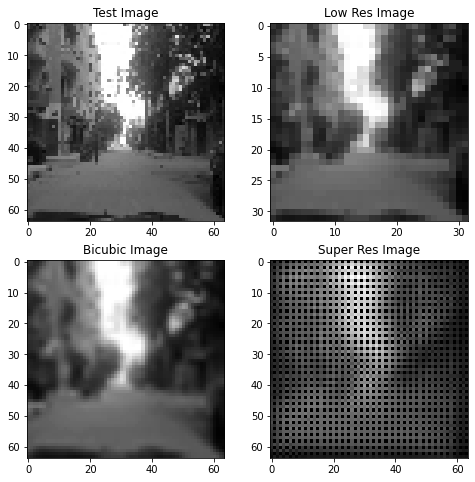

In [90]:
DisplayTestImg(img,lowResImg,biCubicImg,superResImg)